Random Forest AUC: 0.843989048412641
Gradient Boosting AUC: 0.8607411988779281
Selected Model: Gradient Boosting
Generating SHAP Summary Plot...


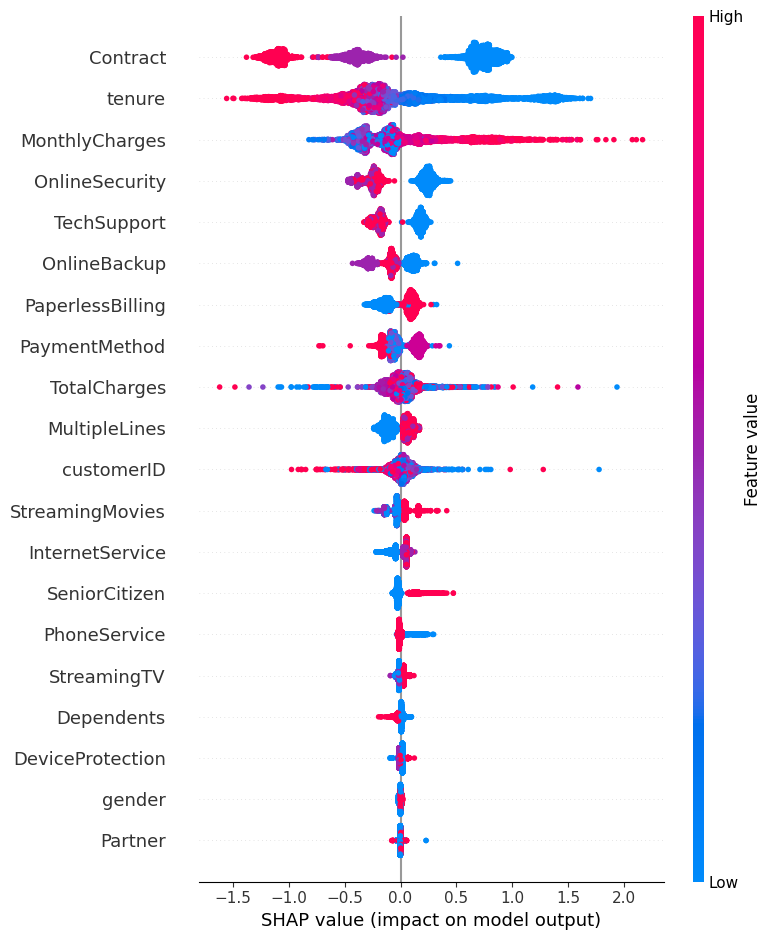

Generating SHAP Bar Plot...


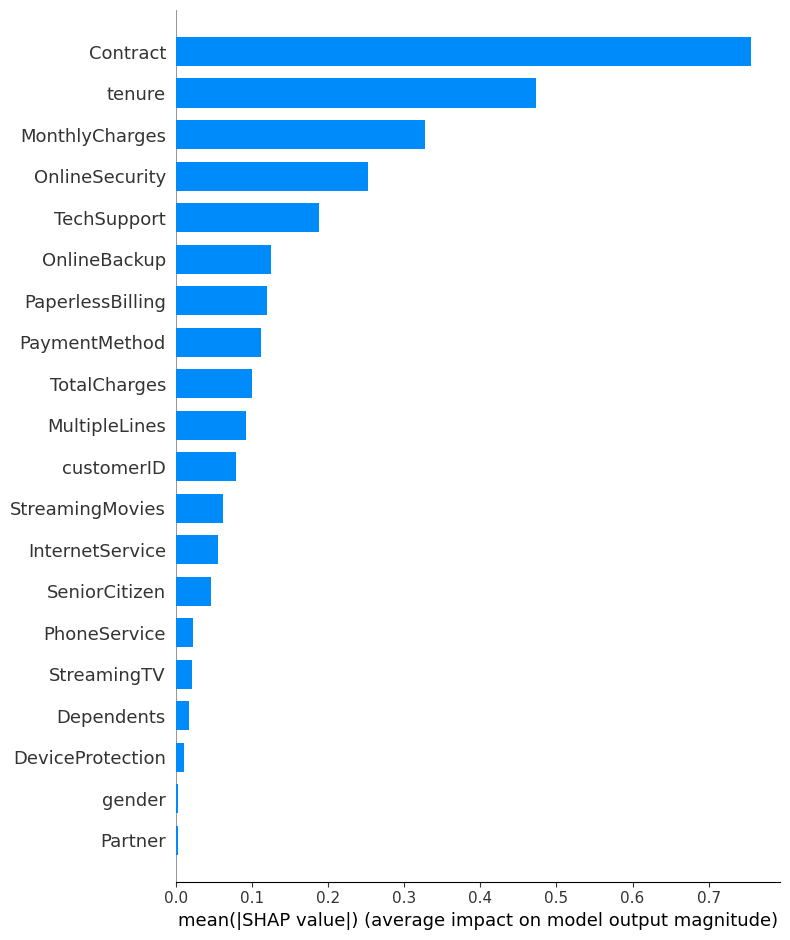


Local SHAP Force Plot for High-Risk Customer 1

Local SHAP Force Plot for High-Risk Customer 2

Local SHAP Force Plot for High-Risk Customer 3

Local SHAP Force Plot for High-Risk Customer 4

Local SHAP Force Plot for High-Risk Customer 5

Top 3 Important Features: ['MonthlyCharges', 'tenure', 'Contract']
Generating dependence plot for: MonthlyCharges


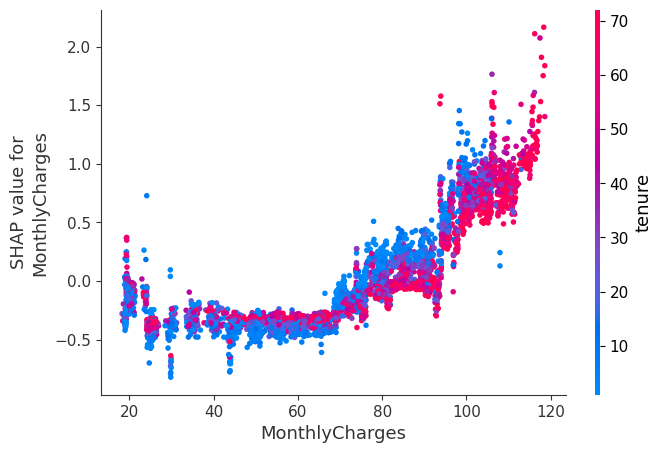

Generating dependence plot for: tenure


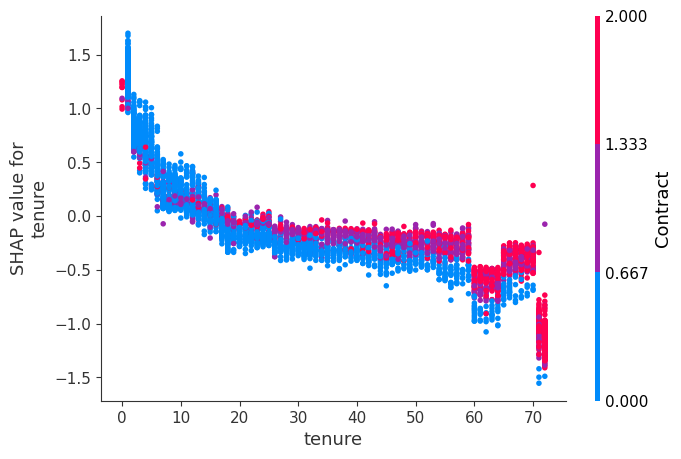

Generating dependence plot for: Contract


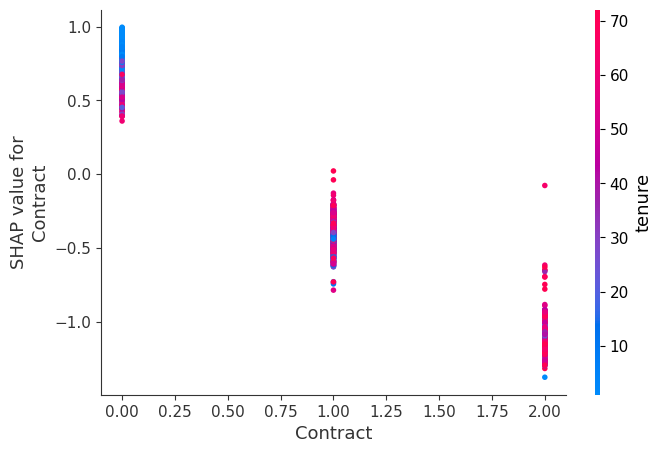


-------------- EXECUTIVE SUMMARY --------------

Top Three Drivers of Customer Churn:
- MonthlyCharges
- tenure
- Contract

Actionable Recommendations:
1. Prioritize retention strategies for customers showing high-risk patterns in these drivers.
2. Provide targeted offers or interventions based on SHAP local explanations.
3. Monitor non-linear interactions found in dependence plots to refine churn policies.



In [1]:

# 1. IMPORT LIBRARIES

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import shap
import matplotlib.pyplot as plt

# 2. LOAD DATA
df = pd.read_csv("C:/Users/DELL/Desktop/Python/WA_Fn-UseC_-Telco-Customer-Churn.csv")

df.shape

# Encode categorical columns
label = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = label.fit_transform(df[col])

# Features & target
X = df.drop("Churn", axis=1)
y = df["Churn"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# 3. TRAIN TWO MODELS (RF & GBM) + COMPARE AUC

rf = RandomForestClassifier(n_estimators=300, random_state=42)
gbm = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05)

rf.fit(X_train, y_train)
gbm.fit(X_train, y_train)

rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
gbm_auc = roc_auc_score(y_test, gbm.predict_proba(X_test)[:,1])

print("Random Forest AUC:", rf_auc)
print("Gradient Boosting AUC:", gbm_auc)


# 4. SELECT SUPERIOR MODEL

if gbm_auc > rf_auc:
    model = gbm
    print("Selected Model: Gradient Boosting")
else:
    model = rf
    print("Selected Model: Random Forest")


# 5. SHAP GLOBAL FEATURE IMPORTANCE

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

print("Generating SHAP Summary Plot...")
shap.summary_plot(shap_values, X_train)

print("Generating SHAP Bar Plot...")
shap.summary_plot(shap_values, X_train, plot_type="bar")

# 6. LOCAL SHAP ANALYSIS FOR FIVE HIGH-RISK CUSTOMERS

X_test_copy = X_test.copy()
X_test_copy["prob"] = model.predict_proba(X_test)[:,1]

# Select top 5 highest churn probability
top5 = X_test_copy.sort_values(by="prob", ascending=False).head(5)
top5_features = top5.drop("prob", axis=1)

shap.initjs()

for i in range(5):
    print(f"\nLocal SHAP Force Plot for High-Risk Customer {i+1}")
    shap.force_plot(
        explainer.expected_value,
        shap_values[top5_features.index[i]],
        top5_features.iloc[i]
    )


# 7. SHAP DEPENDENCE PLOTS FOR TOP 3 FEATURES

top3_features = np.argsort(np.abs(shap_values).mean(0))[-3:]
top3_names = X_train.columns[top3_features]

print("\nTop 3 Important Features:", list(top3_names))

for feature in top3_names:
    print(f"Generating dependence plot for: {feature}")
    shap.dependence_plot(feature, shap_values, X_train)


# 8. EXECUTIVE SUMMARY (AUTO TEXT OUTPUT)

print("\n-------------- EXECUTIVE SUMMARY --------------\n")
print("Top Three Drivers of Customer Churn:")
for f in list(top3_names):
    print(f"- {f}")

print("""
Actionable Recommendations:
1. Prioritize retention strategies for customers showing high-risk patterns in these drivers.
2. Provide targeted offers or interventions based on SHAP local explanations.
3. Monitor non-linear interactions found in dependence plots to refine churn policies.
""")
